In [1]:
import sys
import importlib
from collections import defaultdict

import gym
from gym import spaces
import matplotlib.pyplot as plt
import numpy as np
import random

!{sys.executable} -m pip install ipython-autotime
%load_ext autotime

# River Crossing Environment


1. Actions are four cardinal directions: North, South, East, West
2. States representing a gridworld where the left column and the right column represent the riverbanks, the first row represents the bridge, the last row represents the waterfall and the remaining states represent the river.
3. The transition on the bank and on the bridge has a probability of 0.99 to make the transition and 0.01 to continue in the same state, the transition on the river has a probability of 0.2 to make the transition and 0.8 to move south and If agent reaches the waterfall, it is sent to the starting point.
4. The is on the last state (Bottom right state)
5. Reward is -1 to each transition and 1 on final state

In [2]:
# number of action - North, South, East, West
N_DISCRETE_ACTIONS = 4

class RiverCrossingEnv(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    def __init__(self, shape, stuck=False, s0=None):
        # Define action and observation space
        # They must be gym.spaces objects
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)

        h, w = shape

        #self.observation_space = spaces.Discrete(w * h)
        self.observation_space = spaces.Box(low=0, high=1, shape = (w * h,))

        # probabilities - (state,action)[(state_next, probability,reward),...]
        self.P = {}

        # terminals
        self.G = []
        self.G.append(h * w - 1)

        # defines s0 as the left bottom corner
        if s0 is None:
            self.s0 = w * (h - 1)
        else:
            self.s0 = s0

        self.current_s = self.s0

        for y in range(h):
            for x in range(w):
                for a in range(N_DISCRETE_ACTIONS):
                    s = x + (y * w)
                    s_next = RiverCrossingEnv.find_s_next(x, y, a, shape)

                    default_reward = -1
                    if s == s_next:
                        default_reward = -1
                    if x == w - 1 and y == h - 1:  # G
                        self.P[(s, a)] = [(s, 1, 0)]
                    elif x == 0:  # right
                        self.P[(s, a)] = [(s_next, 0.99, default_reward), (s, 0.01, -1)]
                    elif x == w - 1:  # left
                        self.P[(s, a)] = [(s_next, 0.99, default_reward), (s, 0.01, -1)]
                    elif y == 0:  # bridge
                        self.P[(s, a)] = [(s_next, 0.99, default_reward), (s, 0.01, -1)]
                    elif y == h - 1:  # waterfall
                        # P[(s, a)] = [(s, 1, -1)] #always stuck
                        if stuck:
                            self.P[(s, a)] = [(s_next, 0.1, -1), (s, 0.9, -1)]  # may stuck
                        else:    
                            self.P[(s, a)] = [(self.s0, 1, -1)] #always returns to s0
                        
                        # P[(s, a)] = [(0, 0.999, -1),(s, 0.001, -1)]#may returns to s0
                    else:  # rio
                        self.P[(s, a)] = [(s_next, 0.2, -1), (s + w, 0.8, -1)]

                    #moving to the right direction on s0 to avoid taking to long when doing reinforcement learning
                    if s == self.s0:
                        self.P[(s, a)] = [(s - w, 1, -1)]


    @staticmethod
    def find_s_next(x, y, a, shape):
        h, w = shape
        s = x + (y * w)
        if a == 0:
            s_next = s - w
        elif a == 1:
            s_next = s + w
        elif a == 2:
            s_next = s + 1
        else:
            s_next = s - 1

        # corners
        if x == 0 and a == 3:
            s_next = s
        elif x == w - 1 and a == 2:
            s_next = s
        elif y == 0 and a == 0:
            s_next = s
        elif y == h - 1 and a == 1:
            s_next = s

        return s_next

    def step(self, action):
        # Execute one time step within the environment
        random_number = random.uniform(0, 1)
        t_sum = 0.0
        done = (self.current_s in self.G)
        for s_next, t, r in self.P[(self.current_s, action)]:
            t_sum += t
            if random_number <= t_sum:
                self.current_s = s_next
                return s_next, r, done, {}

    def reset(self):
        # Reset the state of the environment to an initial state
        self.current_s = self.s0
        return self.current_s
  
    def render(self, mode='human', close=False):
        # Render the environment to the screen
        return self.current_s

    @staticmethod
    def draw_policy(V, policy, shape, font_size, plot_value=False):

        values_reshaped = np.reshape(V, shape)
        if policy is not None:
            policy_reshaped = np.reshape(policy, shape)
        else:
            policy_reshaped = np.reshape(np.zeros(len(V)), shape)
        v_max = max(V)
        plt.figure(figsize=(10, 10))
        h, w = shape
        
        ax = plt.gca()
        ax.set_xticks(np.arange(w) - .5)
        ax.set_yticks(np.arange(h) - .5)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        a2uv = {0.0: (0, 1),  # north
                1.0: (0, -1),  # south
                2.0: (1, 0),  # east
                3.0: (-1, 0)  # west
                }

        for y in range(h):
            for x in range(w):

                if plot_value:
                    plt.text(x, y, round(values_reshaped[y, x], 2),
                             color='b', size=font_size / 2, verticalalignment='center',
                             horizontalalignment='center', fontweight='bold')
                else:
                    if y==h-1 and x==w-1:
                        plt.text(x, y, 'G',
                                 color='b', size=font_size, verticalalignment='center',
                                 horizontalalignment='center', fontweight='bold')
                    elif y == h - 1 and x != 0 and x != w - 1:  # cachoeira
                        plt.text(x, y, '-',
                                 color='b', size=font_size, verticalalignment='center',
                                 horizontalalignment='center', fontweight='bold')
                    else:
                        a = policy_reshaped[y, x]
                        if a is None: continue
                        if a < 0:
                            plt.text(x, y, ' ',
                                 color='b', size=font_size, verticalalignment='center',
                                 horizontalalignment='center', fontweight='bold')
                        else:    
                            u, v = a2uv[a]
                            plt.arrow(x, y, u * .2, -v * .2, color='b', head_width=0.2, head_length=0.2)
        plt.grid(color='b', lw=2, ls='-')
        plt.imshow(values_reshaped, cmap='cool')
        plt.show()

    @staticmethod
    def print_result(policy, V, steps, updates, shape, font_size=30):
        if steps > 0:
            print('\n Steps', steps)
        if updates > 0:
            print('\n Updates', updates)

        print("\n Value")
        print(np.reshape(V, shape))

        if policy is not None:
            print("\n Policy")
            print(np.reshape(policy, shape))

        RiverCrossingEnv.draw_policy(V, policy, shape, font_size, True)
        if policy is not None:
            RiverCrossingEnv.draw_policy(V, policy, shape, font_size, False)


time: 12.3 ms


# Value Iteration com exponencial

$$ q^i (s,a) = \sum_{s' \in S} T(s, a, s') \left [  -sign(\lambda) \exp(-\lambda  (R\left ( s, a \right ) + \gamma V^{i-1}(s'))) \right ] $$

$$ V^i\left ( s \right ) \leftarrow \frac{\ln\left(-sign(\lambda) \max_{a}\left ( q^i (s,a) \right ) \right) }{-\lambda} $$

In [3]:
class ValueIterationExp:

    @staticmethod
    def run(env, lamb, gamma, epsilon=1e-3):
        V = np.zeros(env.observation_space.shape[0])
        policy = np.zeros(env.observation_space.shape[0])
        steps = 0
        updates = 0
        diffs = []
        while True:
            steps += 1
            prev_V = np.copy(V)
            for s in range(env.observation_space.shape[0]):
                #calculating action value
                q = np.zeros(env.action_space.n)
                q_updates = 0
                for a in range(env.action_space.n):
                    for s_next, t, r in env.P[(s, a)]:
                        q_updates += 1
                        q[a] += t * (-1 * np.sign(lamb) * np.exp(-lamb * (r + gamma * V[s_next])))

                V[s] = (np.log(-1 * np.sign(lamb) * max(q)) / -lamb)

                policy[s] = np.argmax(q)
                updates += q_updates
            
            diffs.append(np.max(np.fabs(prev_V - V)))

            if np.max(np.fabs(prev_V - V)) < epsilon:
                break
        return policy, V, steps, updates, diffs


time: 2.98 ms


# Testes Value Iteration com exponencial

lamb -1, steps 13

 Steps 13

 Updates 1872

 Value
[[-6.06687338 -5.32822945 -4.55051843 -3.73168156]
 [-6.76840619 -6.0716809  -4.38564769 -2.8695521 ]
 [-6.53580364 -5.82219649 -3.84375998 -1.96184965]
 [-6.63906423 -5.93083365 -3.55981337 -1.00617423]
 [-7.30711102 -7.94175547 -7.94175547  0.        ]]

 Policy
[[2. 2. 2. 1.]
 [0. 2. 2. 1.]
 [2. 2. 2. 1.]
 [2. 2. 2. 1.]
 [0. 0. 0. 0.]]


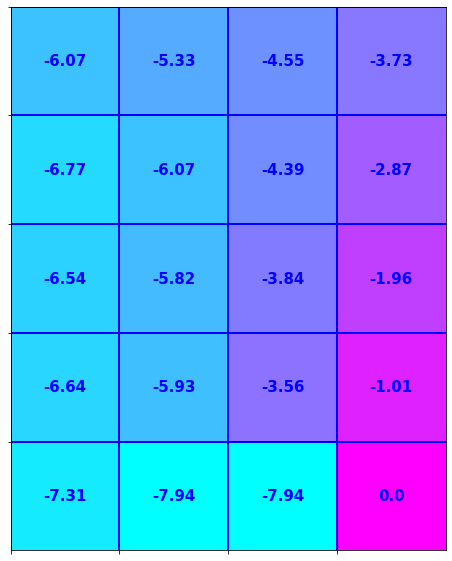

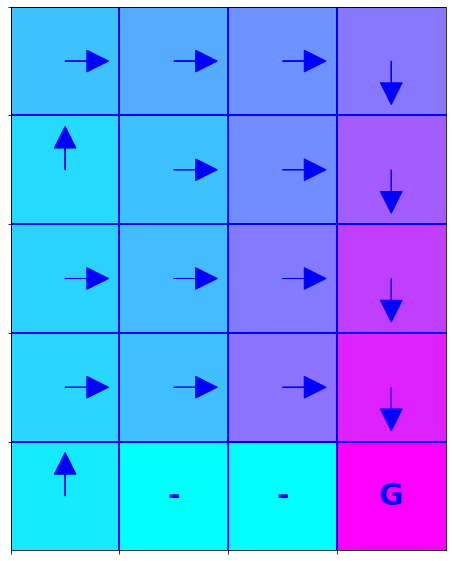

lamb 1, steps 16

 Steps 16

 Updates 2304

 Value
[[ -6.10996601  -5.36819576  -4.58657184  -3.76291899]
 [ -6.81394117 -10.27251896 -10.16861024  -2.89493796]
 [ -7.48207003  -9.99218533  -9.88571352  -1.98019747]
 [ -8.11619792  -9.66786106  -9.58807949  -1.01612554]
 [ -8.71038803  -9.27486863  -9.27486863  -0.        ]]

 Policy
[[2. 2. 2. 1.]
 [0. 0. 2. 1.]
 [0. 3. 2. 1.]
 [0. 3. 2. 1.]
 [0. 0. 0. 0.]]


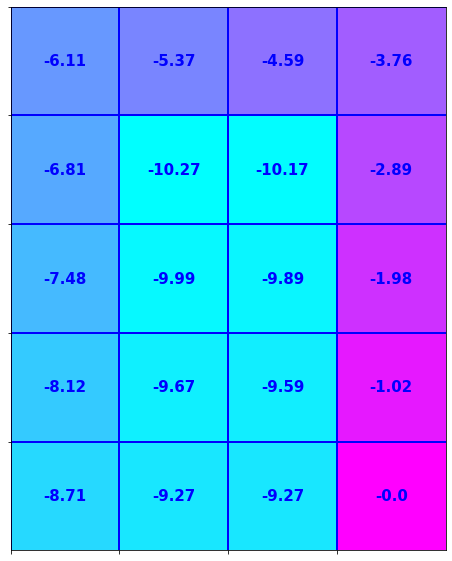

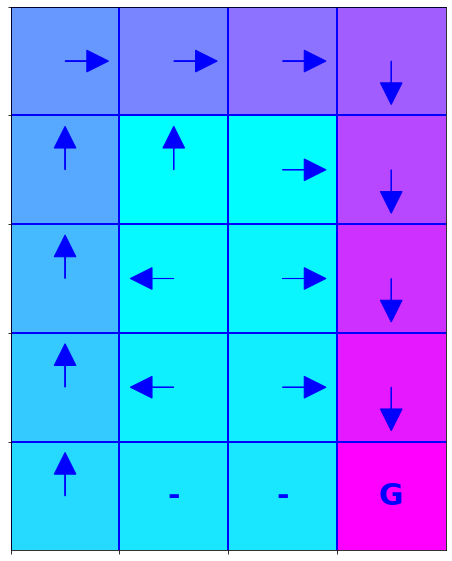

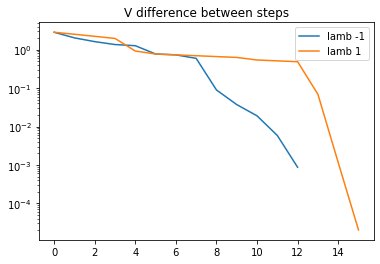

time: 1.24 s


In [4]:
shape = (5, 4) # defining env size
env = RiverCrossingEnv(shape)
gamma = 0.95 # discount factor


#Running risk seeking
lamb = -1 # risk factor
policy, V, steps, updates, diffs = ValueIterationExp.run(env, lamb, gamma)
print('lamb {}, steps {}'.format(lamb, steps))

RiverCrossingEnv.print_result(policy, V, steps, updates, shape)


#Running risk avoiding
lamb = 1 # risk factor
policy, V, steps, updates, diffs2 = ValueIterationExp.run(env, lamb, gamma)
print('lamb {}, steps {}'.format(lamb, steps))


RiverCrossingEnv.print_result(policy, V, steps, updates, shape)


plt.plot(diffs, label='lamb {}'.format(-1))
plt.plot(diffs2, label='lamb {}'.format(1))
plt.yscale(u'log')
plt.title('V difference between steps')
plt.legend()
plt.show()



# Value Iteration implementado no domínio das recompensas $q_{log}$

$$ q^i (s,a) = \sum_{s' \in S} T(s, a, s') \left [  -sign(\lambda) \exp(-\lambda  (R\left ( s, a \right ) + \gamma V^{i-1}(s'))) \right ] $$

$$ V^i\left ( s \right ) = \frac{\ln\left(-sign(\lambda) \max_{a}\left ( q^i (s,a) \right ) \right) }{-\lambda} $$

Sendo:

$$ q_{log} = \frac{-1}{\lambda} log \left ( -sign\left ( \lambda \right) q \right) $$

$$ q = -sign\left ( \lambda \right) \exp\left (-\lambda q_{log}\right)$$


Como V esta no domínio das recompensas, temos que:

$$ V^i\left ( s \right ) = \frac{\ln\left(-sign(\lambda) \max_{a}\left ( -sign\left ( \lambda \right) \exp\left (-\lambda q_{log}^i (s,a) \right) \right ) \right) }{-\lambda} $$

$$ V^i\left ( s \right ) = \max_{a}\left ( q_{log}^i (s,a) \right)$$

Convertendo q para $q_{log}$:

$$ q^i (s,a) = \sum_{s' \in S} T(s, a, s') \left [  -sign(\lambda) \exp(-\lambda  (R\left ( s, a \right ) + \gamma V^{i-1}(s'))) \right ] $$

$$ -sign\left ( \lambda \right) \exp\left (-\lambda q_{log}^i (s,a)\right) = \sum_{s' \in S} T(s, a, s') \left [  -sign(\lambda) \exp(-\lambda  (R\left ( s, a \right ) + \gamma V^{i-1}(s'))) \right ] $$

$$ q_{log}^i (s,a) = \frac{-1}{\lambda} \log \left[  \sum_{s' \in S} \exp \left( \log \left ( T(s, a, s')\right) -\lambda  \left(R\left ( s, a \right ) + \gamma V^{i-1}(s') \right) \right) \right] $$


In [5]:
class ValueIterationExp_q_log:

    @staticmethod
    def run(env, lamb, gamma, epsilon=1e-3):
        V = np.zeros(env.observation_space.shape[0])
        policy = np.zeros(env.observation_space.shape[0])
        steps = 0
        updates = 0
        for i in range(1000):
            steps += 1
            prev_V = np.copy(V)
            for s in range(env.observation_space.shape[0]):
                q_log = np.zeros(env.action_space.n)
                q_updates = 0
                
                for a in range(env.action_space.n):
                    sum_exp = 0
                    for s_next, t, r in env.P[(s, a)]:
                        sum_exp += np.exp(np.log(t)- (lamb * (r + gamma * prev_V[s_next])))
                    
                    q_log[a] = -np.log(sum_exp)/lamb
                            
                
                V[s] = max(q_log)
                

                policy[s] = np.argmax(q_log)
                updates += q_updates

            if np.max(np.fabs(prev_V - V)) < epsilon:
                print('break')
                break
        return policy, V, steps, updates


time: 2.75 ms


# Testes

break
lamb -1, steps 20

 Steps 20

 Value
[[-6.06687338 -5.32822945 -4.55051843 -3.73168156]
 [-6.76840633 -6.07179912 -4.38565456 -2.8695521 ]
 [-6.53599755 -5.82222334 -3.8437614  -1.96184965]
 [-6.63912135 -5.93081688 -3.55981154 -1.00617423]
 [-7.3070385  -7.94144183 -7.94144183  0.        ]]

 Policy
[[2. 2. 2. 1.]
 [0. 2. 2. 1.]
 [2. 2. 2. 1.]
 [2. 2. 2. 1.]
 [0. 0. 0. 0.]]


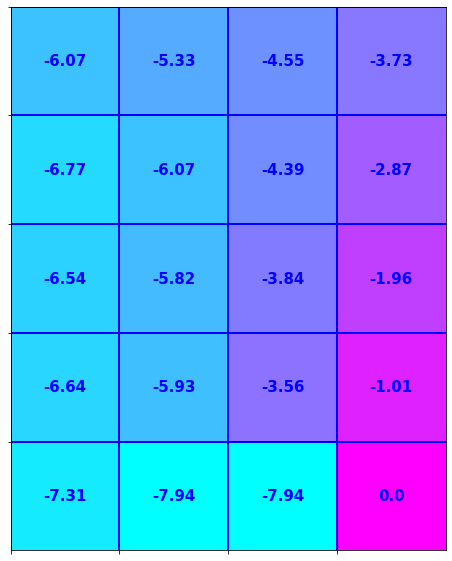

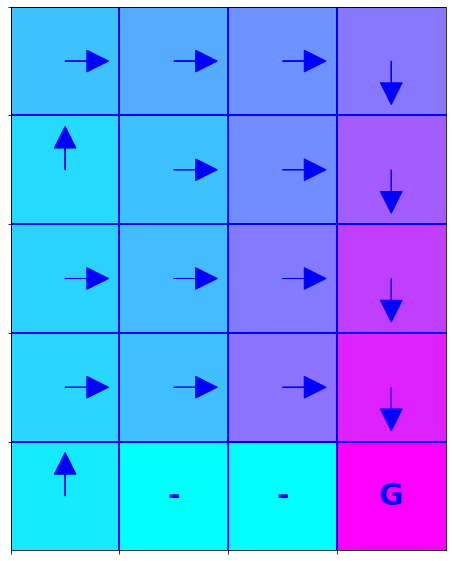

break
lamb 1, steps 18

 Steps 18

 Value
[[ -6.10996601  -5.36819576  -4.58657184  -3.76291899]
 [ -6.81394117 -10.27248331 -10.16857031  -2.89493796]
 [ -7.48207003  -9.99218331  -9.88571127  -1.98019747]
 [ -8.11619792  -9.66786095  -9.58807937  -1.01612554]
 [ -8.71038803  -9.27486862  -9.27486862  -0.        ]]

 Policy
[[2. 2. 2. 1.]
 [0. 0. 2. 1.]
 [0. 3. 2. 1.]
 [0. 3. 2. 1.]
 [0. 0. 0. 0.]]


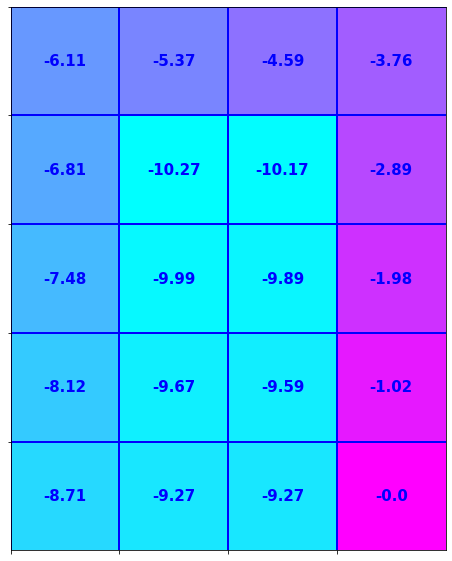

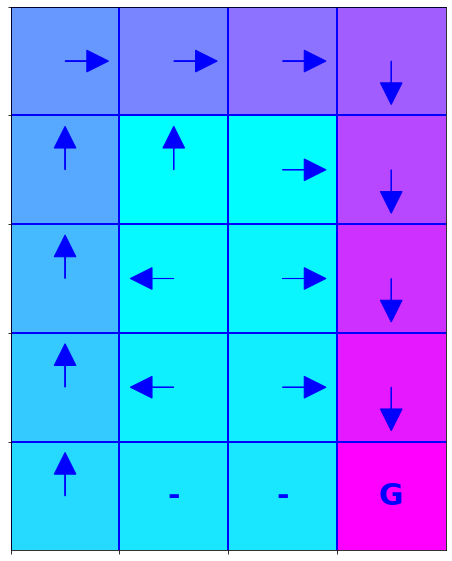

time: 678 ms


In [6]:
shape = (5, 4)
env = RiverCrossingEnv(shape)
gamma = 0.95


#Running risk seeking
lamb = -1
policy, V, steps, updates = ValueIterationExp_q_log.run(env, lamb, gamma)
print('lamb {}, steps {}'.format(lamb, steps))

RiverCrossingEnv.print_result(policy, V, steps, updates, shape)


#Running risk avoiding
lamb = 1
policy, V, steps, updates = ValueIterationExp_q_log.run(env, lamb, gamma)
print('lamb {}, steps {}'.format(lamb, steps))


RiverCrossingEnv.print_result(policy, V, steps, updates, shape)


# Value Iteration implementado com LogSumExp:

$$ q_{log}^i (s,a) = \frac{-1}{\lambda} \log \left[  \sum_{s' \in S} \exp \left( \log \left ( T(s, a, s')\right) -\lambda  \left(R\left ( s, a \right ) + \gamma V^{i-1}(s') \right) \right) \right] $$

$$ V^i\left ( s \right ) = \max_{a}\left ( q_{log}^i (s,a) \right)$$

Temos:

$$ k_{s,s'}^{a,i} = \log \left(T\left(s,a, s'\right)\right) - \lambda \left( R \left ( s, a \right ) + \gamma V^{i-1}(s') \right) $$

$$ K_{s}^{a,i} = \underset{s' \in \S}{\max}(k_{s,s'}^{a,i}). $$

$$ Q_{\log}^{i+1}(s,a) = \frac{-1}{\lambda}K_{s}^{a,i} + \frac{-1}{\lambda}\log \left[ 
 \displaystyle\sum_{ s'\in\mathcal{S}}\exp(k_{s,s'}^{a,i} - K_{s}^{a,i})   \right] $$
 

In [7]:
class ValueIterationExp_LogSumExp:

    @staticmethod
    def run(env, lamb, gamma, epsilon=1e-3):
        V = np.zeros(env.observation_space.shape[0])
        policy = np.zeros(env.observation_space.shape[0])
        steps = 0
        updates = 0
        for i in range(10_000):
            steps += 1
            prev_V = np.copy(V)
            for s in range(env.observation_space.shape[0]):
                #q_log = np.zeros(env.action_space.n)
                
                q_log = np.zeros(env.action_space.n)
                
                q_updates = 0
                
                
                for a in range(env.action_space.n):
                    reward = 0
                    ks = []
                    for s_next, t, r in env.P[(s, a)]:
                        ks.append(np.log(t) - (lamb * (r + gamma * prev_V[s_next])))
                    K = max(ks)
                    
                    sum_k = 0
                    for k in ks:
                        sum_k += np.exp(k - K)
                    
                    q_log[a] = -(K/lamb) - (np.log(sum_k)/lamb)
                    
                V[s] = max(q_log)

                policy[s] = np.argmax(q_log)
                updates += q_updates
            #print("\n Value {}".format(steps))
            #print(np.reshape(V, shape))
            
           
            #print('Not Reached {}: {}'.format(steps,not_reached))
                    
            #print('V3 {}: {}'.format(steps, abs(prev_V[3] - V[3])))
            
            if np.max(np.fabs((prev_V - V))) < epsilon:
                print('break')
                break
        return policy, V, steps, updates


time: 3.1 ms


# Testes

break
lamb -1, steps 20

 Steps 20

 Value
[[-6.06687338 -5.32822945 -4.55051843 -3.73168156]
 [-6.76840633 -6.07179912 -4.38565456 -2.8695521 ]
 [-6.53599755 -5.82222334 -3.8437614  -1.96184965]
 [-6.63912135 -5.93081688 -3.55981154 -1.00617423]
 [-7.3070385  -7.94144183 -7.94144183  0.        ]]

 Policy
[[2. 2. 2. 1.]
 [0. 2. 2. 1.]
 [2. 2. 2. 1.]
 [2. 2. 2. 1.]
 [0. 0. 0. 0.]]


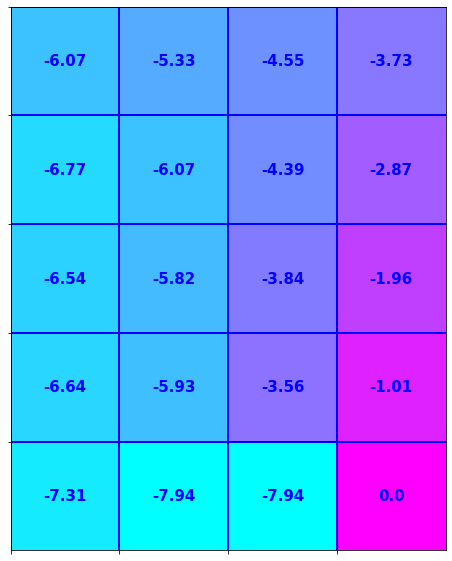

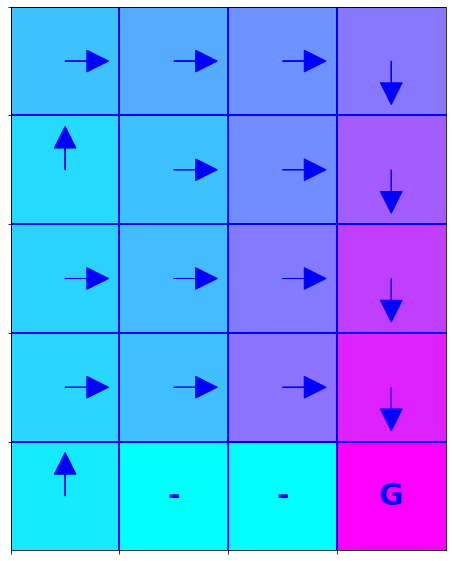

break
lamb 1, steps 18

 Steps 18

 Value
[[ -6.10996601  -5.36819576  -4.58657184  -3.76291899]
 [ -6.81394117 -10.27248331 -10.16857031  -2.89493796]
 [ -7.48207003  -9.99218331  -9.88571127  -1.98019747]
 [ -8.11619792  -9.66786095  -9.58807937  -1.01612554]
 [ -8.71038803  -9.27486862  -9.27486862  -0.        ]]

 Policy
[[2. 2. 2. 1.]
 [0. 0. 2. 1.]
 [0. 3. 2. 1.]
 [0. 3. 2. 1.]
 [0. 0. 0. 0.]]


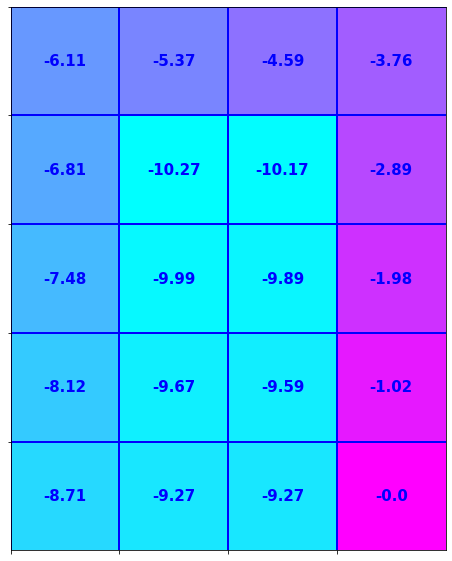

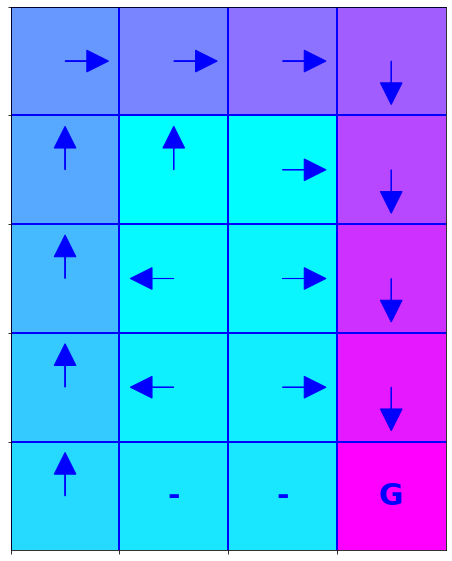

time: 696 ms


In [8]:
shape = (5, 4)
env = RiverCrossingEnv(shape)
gamma = 0.95


#Running risk seeking
lamb = -1
policy, V, steps, updates = ValueIterationExp_LogSumExp.run(env, lamb, gamma)
print('lamb {}, steps {}'.format(lamb, steps))

RiverCrossingEnv.print_result(policy, V, steps, updates, shape)


#Running risk avoiding
lamb = 1
policy, V, steps, updates = ValueIterationExp_LogSumExp.run(env, lamb, gamma)
print('lamb {}, steps {}'.format(lamb, steps))


RiverCrossingEnv.print_result(policy, V, steps, updates, shape)
